# **Analyse, transform, and evaluate the FloodHub data**

In [3]:
import extract
import analyse

# namespace imports
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


Running __init__.py for GoogleFloodHub-data-extractor
GoogleFloodHub-data-extractor initialized


Running __init__.py for GoogleFloodHub-data-analyser
GoogleFloodHub-data-analyser initialized



In [4]:
df_Mali_gauges, df_Mali_gauge_models, df_Mali_forecasts = analyse.get_country_data('Mali', '2024-07-08', '2024-10-08')
df_Kenya_gauges, df_Kenya_gauge_models, df_Kenya_forecasts = analyse.get_country_data('Kenya', '2024-07-10', '2024-10-08')
df_Zambia_gauges, df_Zambia_gauge_models, df_Zambia_forecasts = analyse.get_country_data('Zambia', '2024-07-12', '2024-10-08')

print(len(df_Mali_gauges), len(df_Mali_gauge_models), len(df_Mali_forecasts))
print(len(df_Kenya_gauges), len(df_Kenya_gauge_models), len(df_Kenya_forecasts))
print(len(df_Zambia_gauges), len(df_Zambia_gauge_models), len(df_Zambia_forecasts))

print('\n', df_Mali_forecasts.columns)

16 16 11776
3 3 2168
46 46 32384

 Index(['gaugeId', 'issue_date', 'issue_time', 'fc_date', 'fc_value'], dtype='object')


16 gauges in Mali


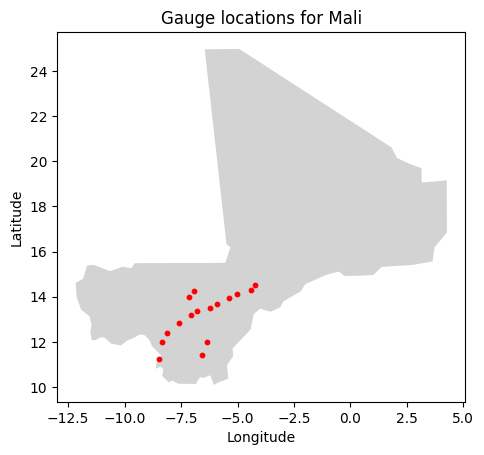

In [5]:
print(len(df_Mali_gauges), 'gauges in Mali')
analyse.map_gauge_coordinates_of_country(
    df_Mali_gauges, 'Mali'
)

##### **Identify the gauges near the Niger river:**

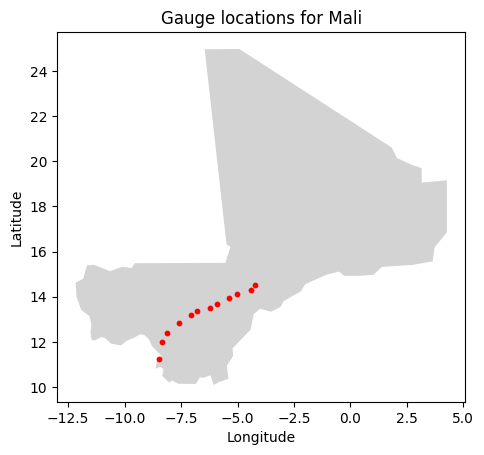

In [6]:
# get just the coordinates from the Mali gauge information
df_Mali_gauge_coords = analyse.subset_country_gauge_coords(df_Mali_gauges)

gauges_not_near_Niger = [
    'hybas_1120739110',
    'hybas_1120758950',
    'hybas_1120650110',
    'hybas_1120661040'
]
# get rid of the gauges not "near" the Niger river
df_Mali_gauges_Niger = \
    df_Mali_gauges[~df_Mali_gauges['gaugeId'].isin([
        'hybas_1120739110',
        'hybas_1120758950',
        'hybas_1120650110',
        'hybas_1120661040'
        ])
    ].copy()

analyse.map_gauge_coordinates_of_country(
    df_Mali_gauges_Niger, 'Mali'
)

In [7]:
df_Mali_gauges_Niger = df_Mali_gauges_Niger.sort_values(
    by = 'latitude',
    ascending = False).reset_index()
print(df_Mali_gauges_Niger['latitude'])

0     14.506250
1     14.314583
2     14.131250
3     13.956250
4     13.685417
5     13.493750
6     13.360417
7     13.210417
8     12.835417
9     12.410417
10    12.018750
11    11.222917
Name: latitude, dtype: float64


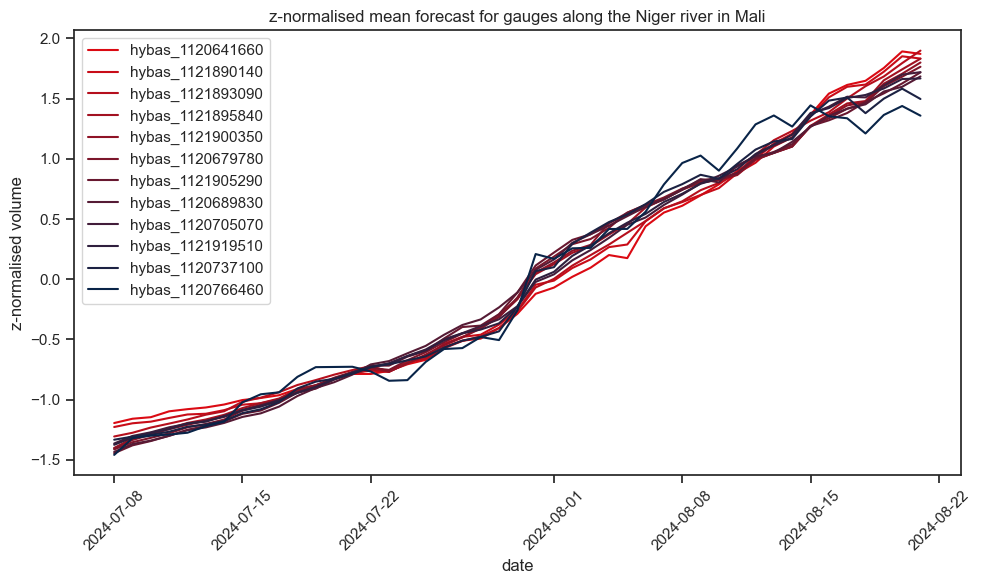

In [8]:
analyse.plot_Niger_river_downstream_flow_stat(
    df_Mali_forecasts,
    datetime.datetime(2024, 7, 8, 0, 0),
    df_Mali_gauges_Niger['gaugeId'].to_list(),
    45,
    'mean'
)

In [9]:
# Calculate Niger cross-correlation and propagation time:
# Some problems:
# - Is detrending needed? Or, in other words, is non-stationarity a problem?
# - The stations aren't spatially uniformly distributed--is this OK?

# **Explorative stats/plots**

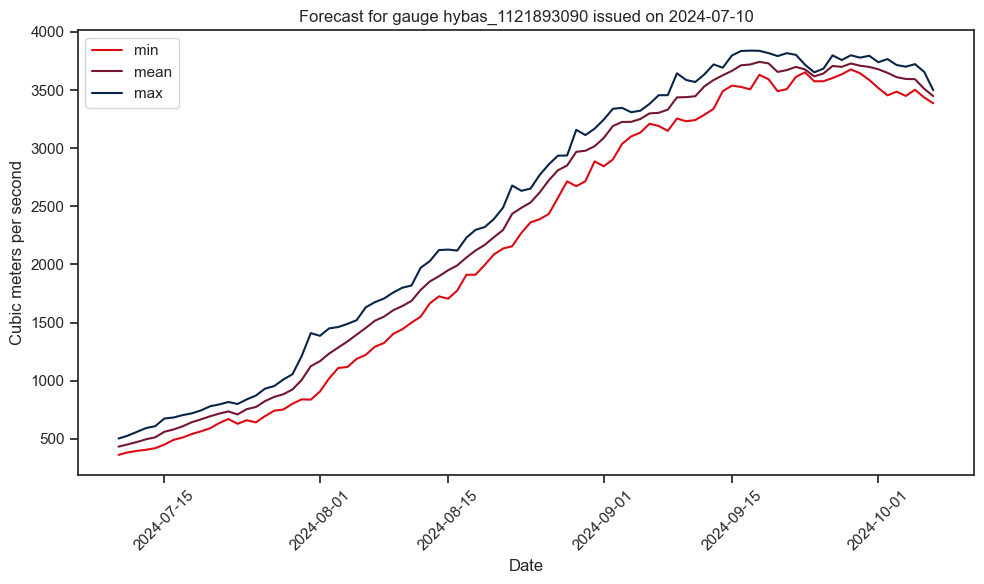

In [10]:
issue_time = datetime.datetime(2024, 10, 8, 0, 0) - datetime.timedelta(days = 90)

analyse.plot_forecast_min_mean_max(
    df_Mali_forecasts,                      # the forecasts
    issue_time,                             # the issue time
    df_Mali_gauges['gaugeId'].to_list()[0], # the gauge
    90                                      # the number of days
)

No forecasted values for gauge hybas_1121893090 at 2024-08-13


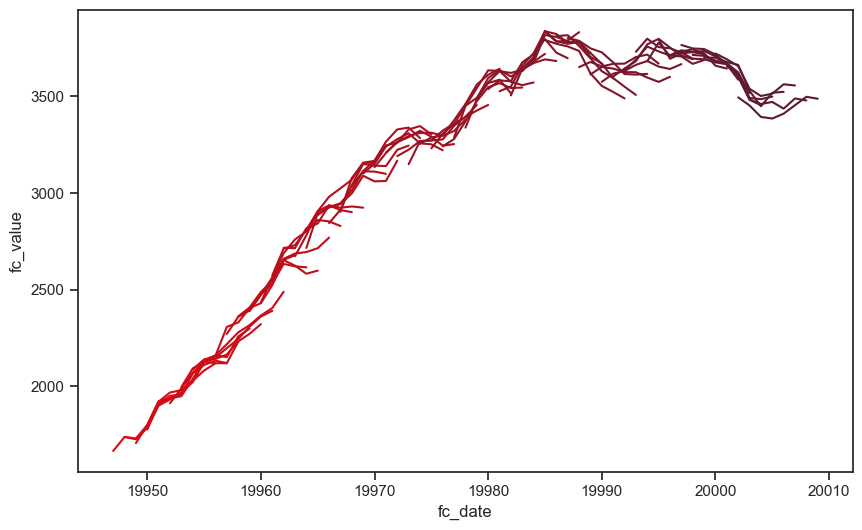

In [11]:
start_date = datetime.datetime.now() - datetime.timedelta(days = 90)

analyse.plot_x_days_of_gauge_forecast_for_issue_time(
    df_Mali_forecasts,                      # plot for Mali
    df_Mali_gauges['gaugeId'].to_list()[0], # plot for the first gauge
    start_date,                             # plot starts 90 days ago (relative to today)
    90,                                     # plot for 90 days (relative to start date)                                                  
    'Mali',                                 # country name (don't forget the capital letter)
)

In [12]:
print(df_Mali_forecasts.head(2))

            gaugeId issue_date                        issue_time     fc_date  \
0  hybas_1120641660 2024-07-08  2024-07-08 13:54:03.433896+00:00  2024-07-07   
1  hybas_1120641660 2024-07-08  2024-07-08 13:54:03.433896+00:00  2024-07-08   

     fc_value  
0  238.515350  
1  247.505783  


# **Station-to-administrative-unit classification**

In [32]:
red = '#DB0A13'
blue = '#092448'

In [13]:
import geopandas as gpd

# Path to the shape file with admin level 2 units for Mali
path_Mali_shp_adm2 = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp'
# Read the shape file into a GeoDataFrame and convert it to WGS84
# (which is the coordinate system used by the gauge data)
gpd_adm_units_Mali = analyse.get_shape_file(path_Mali_shp_adm2).to_crs('EPSG:4326')
print(type(gpd_adm_units_Mali)) # Should be a GeoDataFrame

<class 'geopandas.geodataframe.GeoDataFrame'>


In [14]:
# Create a GeoDataFrame from the gauge coordinates;
# geometry is a point for each gauge, with coords (x, y)
gpd_Mali_gauge_coords = gpd.GeoDataFrame(
    df_Mali_gauge_coords,
    geometry = gpd.points_from_xy(df_Mali_gauge_coords.longitude, df_Mali_gauge_coords.latitude),
    crs = 'EPSG:4326'
)
print(type(gpd_Mali_gauge_coords))


# Check if the coord systems are the same
if gpd_adm_units_Mali.crs != gpd_Mali_gauge_coords.crs:
    gpd_adm_units_Mal = gpd_adm_units_Mali.to_crs(gpd_Mali_gauge_coords.crs)
analyse.assert_same_coord_system(gpd_adm_units_Mali, gpd_Mali_gauge_coords)

<class 'geopandas.geodataframe.GeoDataFrame'>


In [15]:
# Creates a joined dataframe with the gauges as basis, meaning
# that gauges get assigned to the admin unit they are within,
# including their metadata (such as the shape of the admin unit).
# (And, thus, the rest of the admin units are not considered.)
gpd_gauges_classified = gpd.sjoin(
    gpd_Mali_gauge_coords,
    gpd_adm_units_Mali,
    how = 'left',           # joins left, i.e. the gauges serve as basis
    predicate = 'within',   # checks if the gauge is within the admin unit
    lsuffix = 'gauge',
    rsuffix = 'adm'
)

print(type(gpd_gauges_classified))  # Should be a GeoDataFrame
print(len(gpd_gauges_classified))   # Should print 16, as there are 16 gauges in Mali
print(gpd_gauges_classified.head(2))

<class 'geopandas.geodataframe.GeoDataFrame'>
16
            gaugeId   latitude  longitude                   geometry  \
0  hybas_1121893090  14.131250  -5.039583  POINT (-5.03958 14.13125)   
1  hybas_1121890140  14.314583  -4.422917  POINT (-4.42292 14.31458)   

   index_adm  Shape_Leng  Shape_Area   ADM2_FR ADM2_PCODE  ADM2_REF  \
0       34.0    4.894504    0.981994  Ténenkou     ML0507  Tenenkou   
1       33.0    5.438311    0.611429     Mopti     ML0506      None   

  ADM2ALT1FR ADM2ALT2FR ADM1_FR ADM1_PCODE    ADM0_FR ADM0_PCODE       date  \
0       None       None   Mopti       ML05  Mali (le)         ML 2015-06-01   
1       None       None   Mopti       ML05  Mali (le)         ML 2015-06-01   

     validOn     validTo  
0 2021-12-20  0000/00/00  
1 2021-12-20  0000/00/00  


In [22]:
# Save as GEOJSON
gpd_gauges_classified.to_file(
    '../data/processed/gauge_adm_units/mali_gauges_adm_units.geojson',
    driver = 'GeoJSON'
)

# Load GEOJSON back in
gpd_gauges_classified = gpd.read_file(
    '../data/processed/gauge_adm_units/mali_gauges_adm_units.geojson'
)

In [38]:
# Now, we want to make a plot where each administrative unit with
# a gauge gets a tinted colour. Thus, we now join the GeoDataFrames
# the other way around, and use the admin units left to plot over
# all off the administrative units

gpd_adm_units_with_gauges = gpd.sjoin(
    gpd_adm_units_Mali,
    gpd_Mali_gauge_coords,
    how = 'left',
    predicate = 'contains',
    lsuffix = 'adm',
    rsuffix = 'gauge'
)

print('Administrative units in Mali:', len(gpd_adm_units_Mali))
# Drop the column where index_gauge (aka index_right) is NaN,
# because that means that the admin unit does not contain a gauge
gpd_adm_units_with_gauges = gpd_adm_units_with_gauges.dropna(subset = ['index_gauge'])
# 15 gauges left, so there's one administrative unit with two gauges
print('Administrative units with a gauge:', len(gpd_adm_units_with_gauges))

Administrative units in Mali: 53
Administrative units with a gauge: 15


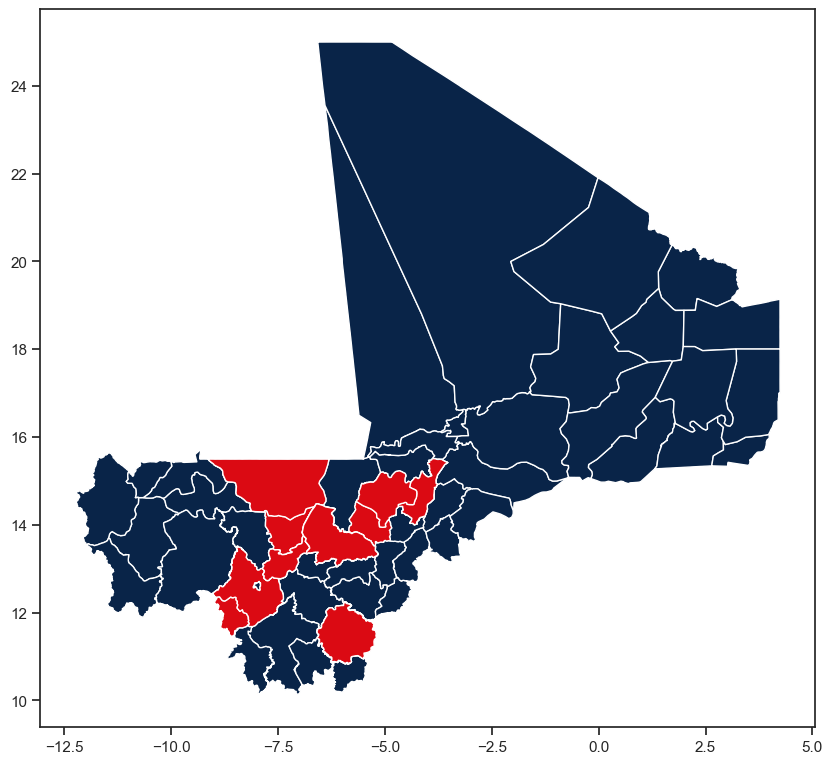

In [33]:
fig, ax = plt.subplots(figsize = (10, 10))
gpd_adm_units_Mali.plot(ax = ax, color = blue)
gpd_adm_units_with_gauges.plot(ax = ax, color = red)
plt.show()